In [34]:
# Importing necessary models
import warnings
warnings.filterwarnings('ignore')

import smtplib
import pandas as pd
import numpy as np
import datetime as dt
import pandas.stats.moments as st
import time
%matplotlib inline
from bs4 import BeautifulSoup as bs
import requests
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sqlalchemy import *
from sqlalchemy import create_engine
import calendar
import sqlite3 as sql
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.4f}'.format
from scipy.stats import norm as norm
init_notebook_mode(connected=True)

import os

dbs_dir = 'D:\Options Data\SPX'

os.chdir('D:\Price Data\SPX and VIX Intraday TWS')

ib_index_engine = create_engine('sqlite:///ib_index_intraday.db', echo = False)

os.chdir(dbs_dir)

spx_options_engine = create_engine('sqlite:///spx_options.db', echo = False)

In [2]:
query = "SELECT date, open_spx, high_spx, low_spx, close_spx, open_vix, high_vix, low_vix, close_vix FROM indexIntraday"

minutes_mod = 30

index_intraday = pd.read_sql_query(query, con = ib_index_engine, index_col = 'date')
index_intraday.index = pd.to_datetime(index_intraday.index)
index_intraday = index_intraday.sort_index()
index_intraday['date_day'] = index_intraday.index.date
index_intraday['EOD'] = (index_intraday['date_day'].shift(-1) - index_intraday['date_day']).dt.days
index_intraday['BOD'] = (index_intraday['date_day'].shift(1) - index_intraday['date_day']).dt.days
index_intraday = index_intraday.fillna(1)
index_intraday['TimeFilter'] = index_intraday.index.minute%minutes_mod


In [88]:
options_files = sorted(os.listdir())

daylights_savings = dt.datetime(2018,11,4)

period_window = 60
commissions = 0.0266
number_of_contracts = 6


only_0dte = True

ps_holdings = []
cs_holdings = []

pnl_track = []
nav_track = []

for curr_file_date in sorted(list(set(list(map(lambda x: x.split('.')[0][:-6].replace('spx_',''), options_files))))):
    
    curr_datetime = dt.datetime.strptime(curr_file_date, '%Y-%m-%d')
    
    try:
        if curr_datetime.date() in index_intraday.date_day.drop_duplicates().tolist():

            curr_files = sorted(list(filter(lambda x: curr_file_date in x, options_files)))[6:]

            put_holdings = pd.DataFrame(columns = ['Quote_Time','DTE','Short_Symbol','Long_Symbol','Short_Bid','Long_Ask', 'Commissions'])
            call_holdings = pd.DataFrame(columns = ['Quote_Time','DTE','Short_Symbol','Long_Symbol','Short_Bid','Long_Ask', 'Commissions'])


            time_count = 0
            for filename in curr_files:
                curr_options = pd.read_csv(filename, index_col = 0)[['Strike','Expiry','Type','Symbol','Bid','Ask','Vol','Open_Int',
                                                                     'IV','Underlying_Price','Quote_Time']]

                curr_options.Quote_Time = pd.to_datetime(curr_options.Quote_Time).map(lambda x: x.replace(second=0))

                if curr_options.Quote_Time[0] < daylights_savings:
                    curr_options.Quote_Time = curr_options.Quote_Time - dt.timedelta(seconds = 60*60*7)
                else:
                    curr_options.Quote_Time = curr_options.Quote_Time - dt.timedelta(seconds = 60*60*8)

                curr_options.Expiry = pd.to_datetime(curr_options.Expiry)

                curr_options['DTE'] = (curr_options.Expiry - curr_options.Quote_Time).dt.days + 1

                curr_time = curr_options.loc[0,'Quote_Time']

                if only_0dte:
                    if curr_options['DTE'].min() > 0:
                        break

                calls = curr_options[(curr_options.Type == 'call') &
                                     (curr_options.DTE == curr_options['DTE'].min())].sort_values('Strike').reset_index(drop = True)
                puts = curr_options[(curr_options.Type == 'put') &
                                    (curr_options.DTE == curr_options['DTE'].min())].sort_values('Strike').reset_index(drop = True)

                curr_index_data = index_intraday[index_intraday.index == curr_time]

                if len(curr_index_data) == 0:
                    curr_index_data = index_intraday[index_intraday.index == curr_time + dt.timedelta(seconds = 60)]

                    if curr_time.time() == dt.time(13, 0):
                        curr_index_data = index_intraday[index_intraday.index == curr_time - dt.timedelta(seconds = 60)]

                if curr_time.time() > dt.time(13,0):
                    break

                curr_spx = curr_index_data.reset_index().loc[0, 'close_spx']
                curr_scaled_vix = curr_index_data.reset_index().loc[0, 'close_vix']/(np.sqrt(365*(390/period_window))*100)
                upper_spx_bound = (1 + curr_scaled_vix)*curr_spx
                lower_spx_bound = (1 - curr_scaled_vix)*curr_spx

                curr_put_contracts = puts[puts.Strike <= lower_spx_bound].tail(2).reset_index(drop = True)
                curr_call_contracts = calls[calls.Strike >= upper_spx_bound].head(2).reset_index(drop = True)


                curr_ps = pd.DataFrame(columns = ['Quote_Time','DTE','Short_Symbol','Long_Symbol','Short_Bid','Long_Ask','Commissions'],
                           index = [0])
                curr_ps.loc[0, 'Quote_Time'] = curr_put_contracts.loc[0, 'Quote_Time']
                curr_ps.loc[0, 'DTE'] = curr_put_contracts.loc[0, 'DTE']
                curr_ps.loc[0, 'Short_Symbol'] = curr_put_contracts.loc[1, 'Symbol']
                curr_ps.loc[0, 'Long_Symbol'] = curr_put_contracts.loc[0, 'Symbol']
                curr_ps.loc[0, 'Short_Bid'] = curr_put_contracts.loc[1, 'Bid']
                curr_ps.loc[0, 'Long_Ask'] = curr_put_contracts.loc[0, 'Ask']

                curr_cs = pd.DataFrame(columns = ['Quote_Time','DTE','Short_Symbol','Long_Symbol','Short_Bid','Long_Ask','Commissions'],
                           index = [0])
                curr_cs.loc[0, 'Quote_Time'] = curr_call_contracts.loc[0, 'Quote_Time']
                curr_cs.loc[0, 'DTE'] = curr_call_contracts.loc[0, 'DTE']
                curr_cs.loc[0, 'Short_Symbol'] = curr_call_contracts.loc[0, 'Symbol']
                curr_cs.loc[0, 'Long_Symbol'] = curr_call_contracts.loc[1, 'Symbol']
                curr_cs.loc[0, 'Short_Bid'] = curr_call_contracts.loc[0, 'Bid']
                curr_cs.loc[0, 'Long_Ask'] = curr_call_contracts.loc[1, 'Ask']

                if time_count == period_window/5 or time_count == 0:

                    if len(put_holdings) > 0:
                        prior_ps = put_holdings.tail(1).reset_index(drop = True)

                        if prior_ps.loc[0, 'Short_Symbol'] != curr_ps.loc[0, 'Short_Symbol'] or prior_ps.loc[0, 'Long_Symbol'] != curr_ps.loc[0, 'Long_Symbol']:
                            prior_ps.loc[0, 'Quote_Time'] = curr_put_contracts.loc[0, 'Quote_Time']

                            curr_short_put_holding = puts[puts.Symbol == prior_ps.loc[0, 'Short_Symbol']].reset_index(drop = True)
                            curr_long_put_holding = puts[puts.Symbol == prior_ps.loc[0, 'Long_Symbol']].reset_index(drop = True)
                            prior_ps.loc[0, 'Short_Bid'] = curr_short_put_holding.loc[0, 'Bid']
                            prior_ps.loc[0, 'Long_Ask'] = curr_long_put_holding.loc[0, 'Ask']

                            prior_ps.loc[0, 'Commissions'] = commissions
                            put_holdings = put_holdings.append(prior_ps)

                            curr_ps.loc[0, 'Commissions'] = commissions
                        else:
                            curr_ps.loc[0, 'Commissions'] = 0

                        prior_cs = call_holdings.tail(1).reset_index(drop = True)

                        if prior_cs.loc[0, 'Short_Symbol'] != curr_cs.loc[0, 'Short_Symbol'] or prior_cs.loc[0, 'Long_Symbol'] != curr_cs.loc[0, 'Long_Symbol']:
                            prior_cs.loc[0, 'Quote_Time'] = curr_call_contracts.loc[0, 'Quote_Time']

                            curr_short_call_holding = calls[calls.Symbol == prior_cs.loc[0, 'Short_Symbol']].reset_index(drop = True)
                            curr_long_call_holding = calls[calls.Symbol == prior_cs.loc[0, 'Long_Symbol']].reset_index(drop = True)
                            prior_cs.loc[0, 'Short_Bid'] = curr_short_call_holding.loc[0, 'Bid']
                            prior_cs.loc[0, 'Long_Ask'] = curr_long_call_holding.loc[0, 'Ask']

                            prior_cs.loc[0, 'Commissions'] = commissions
                            call_holdings = call_holdings.append(prior_cs)

                            curr_cs.loc[0, 'Commissions'] = commissions
                        else:
                            curr_cs.loc[0, 'Commissions'] = 0

                    if len(put_holdings) == 0:
                        curr_ps.loc[0, 'Commissions'] = commissions

                    if len(put_holdings) == 0:
                        curr_cs.loc[0, 'Commissions'] = commissions

                    put_holdings = put_holdings.append(curr_ps)
                    call_holdings = call_holdings.append(curr_cs)

                    time_count = 0
                else:
                    curr_ps = put_holdings.tail(1).reset_index(drop = True)
                    curr_ps.loc[0, 'Quote_Time'] = curr_put_contracts.loc[0, 'Quote_Time']

                    curr_short_put_holding = puts[puts.Symbol == curr_ps.loc[0, 'Short_Symbol']].reset_index(drop = True)
                    curr_long_put_holding = puts[puts.Symbol == curr_ps.loc[0, 'Long_Symbol']].reset_index(drop = True)
                    curr_ps.loc[0, 'Short_Bid'] = curr_short_put_holding.loc[0, 'Bid']
                    curr_ps.loc[0, 'Long_Ask'] = curr_long_put_holding.loc[0, 'Ask']

                    curr_cs = call_holdings.tail(1).reset_index(drop = True)
                    curr_cs.loc[0, 'Quote_Time'] = curr_call_contracts.loc[0, 'Quote_Time']

                    curr_short_call_holding = calls[calls.Symbol == curr_cs.loc[0, 'Short_Symbol']].reset_index(drop = True)
                    curr_long_call_holding = calls[calls.Symbol == curr_cs.loc[0, 'Long_Symbol']].reset_index(drop = True)
                    curr_cs.loc[0, 'Short_Bid'] = curr_short_call_holding.loc[0, 'Bid']
                    curr_cs.loc[0, 'Long_Ask'] = curr_long_call_holding.loc[0, 'Ask']

                    curr_ps.loc[0, 'Commissions'] = 0
                    curr_cs.loc[0, 'Commissions'] = 0

                    put_holdings = put_holdings.append(curr_ps)
                    call_holdings = call_holdings.append(curr_cs)

                time_count += 1

            if len(put_holdings) > 0:
                put_holdings['SpreadNAV'] = (put_holdings.Short_Bid - put_holdings.Long_Ask - put_holdings.Commissions)*number_of_contracts*100

                ps_pnl = -put_holdings[['Quote_Time','SpreadNAV']].groupby('Quote_Time').sum().diff()
                ps_pnl.columns = ['ps_pnl']

                call_holdings['SpreadNAV'] = (call_holdings.Short_Bid - call_holdings.Long_Ask - call_holdings.Commissions)*number_of_contracts*100

                cs_pnl = -call_holdings[['Quote_Time','SpreadNAV']].groupby('Quote_Time').sum().diff()
                cs_pnl.columns = ['cs_pnl']

                daily_pnl = ps_pnl.join(cs_pnl)
                daily_pnl['total_pnl'] = daily_pnl.ps_pnl + daily_pnl.cs_pnl

                nav_track.append(daily_pnl)

                ps_holdings.append(put_holdings)
                cs_holdings.append(call_holdings)

                daily_pnl = daily_pnl.expanding(1).sum()

                pnl_track.append(daily_pnl)
            print("Completed " + curr_file_date)
        else:
            continue
    except:
        continue

Completed 2018-07-30
Completed 2018-07-31
Completed 2018-08-01
Completed 2018-08-02
Completed 2018-08-03
Completed 2018-08-06
Completed 2018-08-07
Completed 2018-08-08
Completed 2018-08-09
Completed 2018-08-10
Completed 2018-08-13
Completed 2018-08-14
Completed 2018-08-15
Completed 2018-08-16
Completed 2018-08-17
Completed 2018-08-20
Completed 2018-08-21
Completed 2018-08-22
Completed 2018-08-23
Completed 2018-08-24
Completed 2018-08-27
Completed 2018-08-28
Completed 2018-08-29
Completed 2018-08-30
Completed 2018-08-31
Completed 2018-09-04
Completed 2018-09-05
Completed 2018-09-06
Completed 2018-09-07
Completed 2018-09-10
Completed 2018-09-11
Completed 2018-09-12
Completed 2018-09-13
Completed 2018-09-14
Completed 2018-09-17
Completed 2018-09-18
Completed 2018-09-19
Completed 2018-09-20
Completed 2018-09-21
Completed 2018-09-24
Completed 2018-09-25
Completed 2018-09-26
Completed 2018-09-27
Completed 2018-09-28
Completed 2018-10-01
Completed 2018-10-02
Completed 2018-10-03
Completed 201

In [89]:
ps_holdings_df = pd.concat(ps_holdings, axis = 0)
cs_holdings_df = pd.concat(cs_holdings, axis = 0)

pnl_track_df = pd.concat(pnl_track, axis = 0)
nav_track_df = pd.concat(nav_track, axis = 0)

2018-07-30
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-07-30 12:59:00 135.9600 284.0400   420.0000 2,802.3200


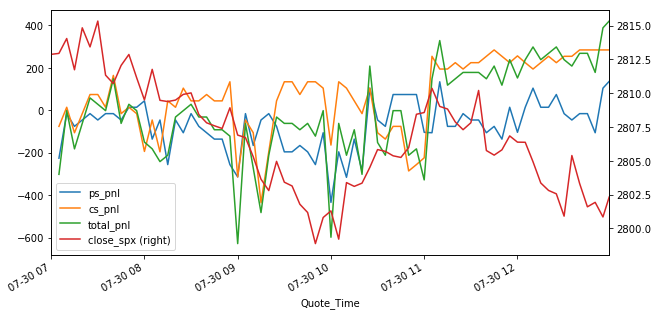

2018-07-31
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-07-31 13:00:00 134.0400 945.9600 1,080.0000        nan


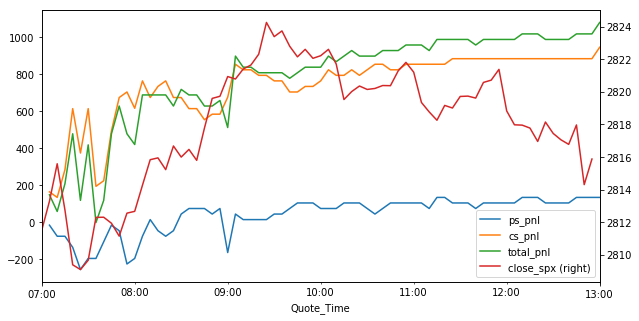

2018-08-01
                     ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                
2018-08-01 13:00:00 44.0400 344.0400   388.0800        nan


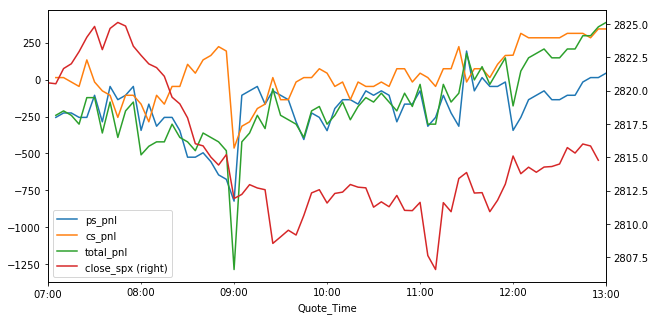

2018-08-03
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-08-03 13:00:00 404.0400 405.9600   810.0000        nan


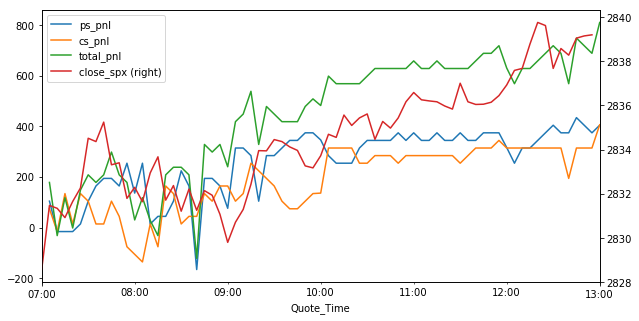

2018-08-06
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-08-06 13:00:00 344.0400 194.0400   538.0800        nan


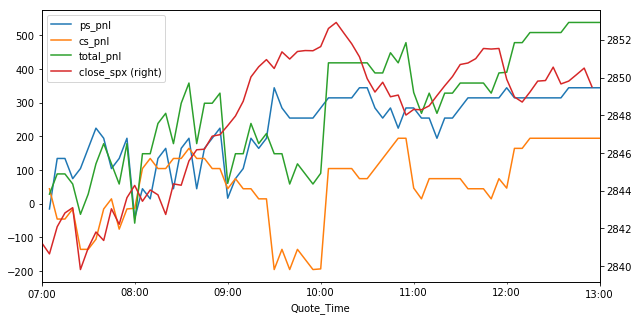

2018-08-08
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-08-08 13:00:00 104.0400 315.9600   420.0000        nan


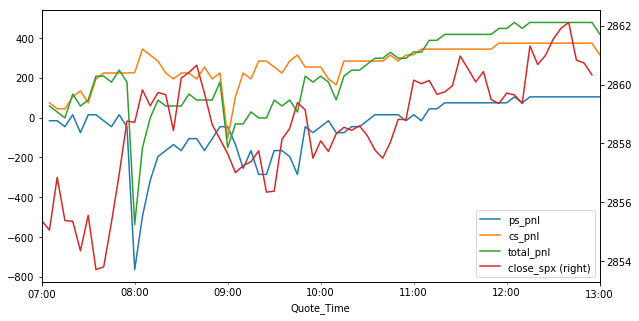

2018-08-10
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-08-10 13:00:00 135.9600 105.9600   241.9200        nan


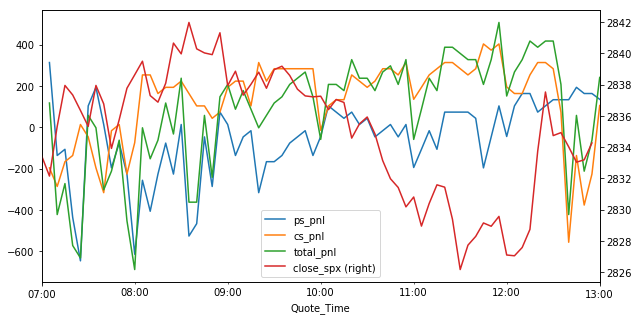

2018-08-13
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-08-13 12:59:00 525.9600 194.0400   720.0000 2,821.8800


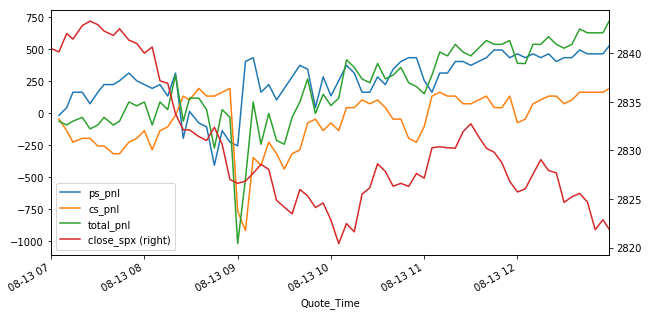

2018-08-15
                      ps_pnl     cs_pnl  total_pnl  close_spx
Quote_Time                                                   
2018-08-15 13:00:00 105.9600 1,665.9600 1,771.9200        nan


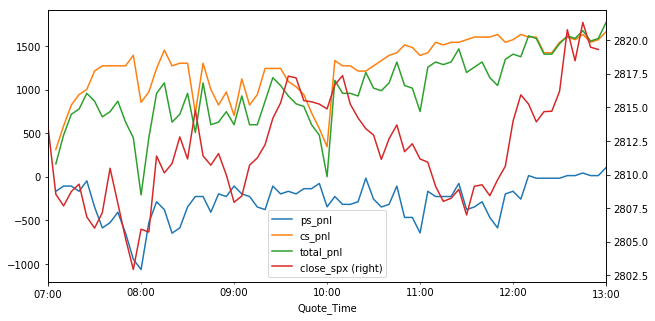

2018-08-17
                         ps_pnl   cs_pnl   total_pnl  close_spx
Quote_Time                                                     
2018-08-17 13:00:00 -1,694.0400 495.9600 -1,198.0800        nan


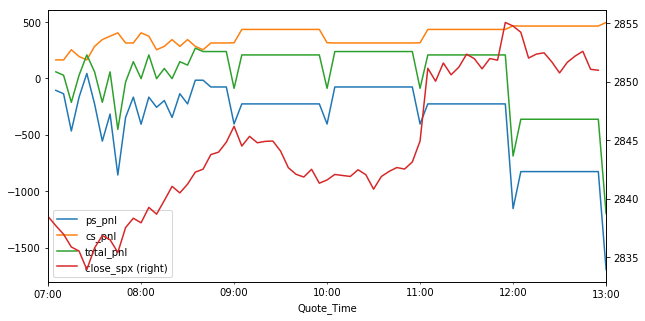

2018-08-20
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-08-20 13:00:00 344.0400 194.0400   538.0800        nan


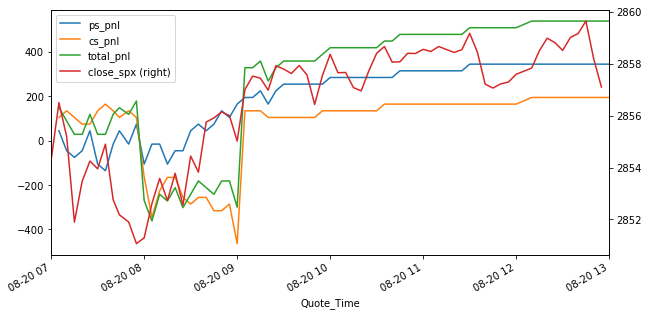

2018-08-24
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-08-24 13:00:00 254.0400 314.0400   568.0800        nan


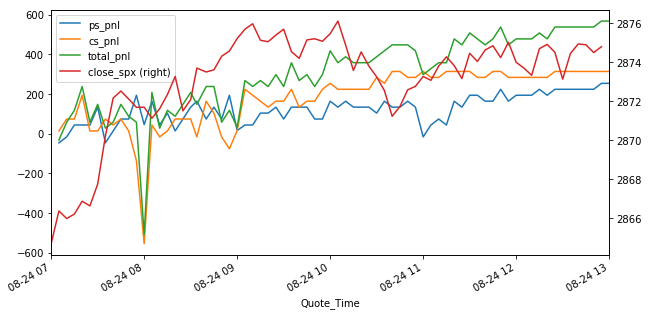

2018-08-31
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-08-31 13:00:00 525.9600 285.9600   811.9200        nan


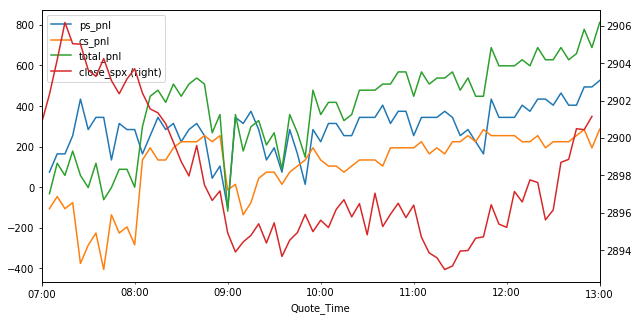

2018-09-07
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-09-07 13:00:00 -74.0400 434.0400   360.0000        nan


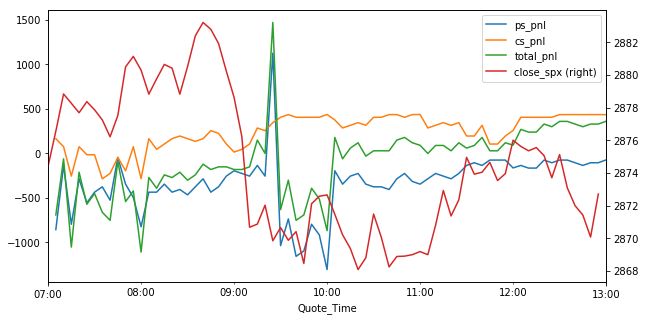

2018-09-14
                     ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                
2018-09-14 13:00:00 44.0400 314.0400   358.0800        nan


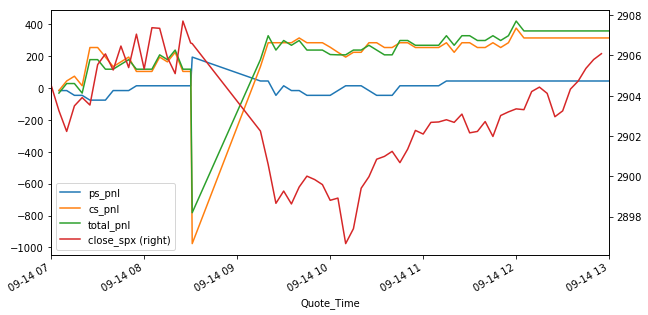

2018-09-21
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-09-21 13:00:00 224.0400 524.0400   748.0800        nan


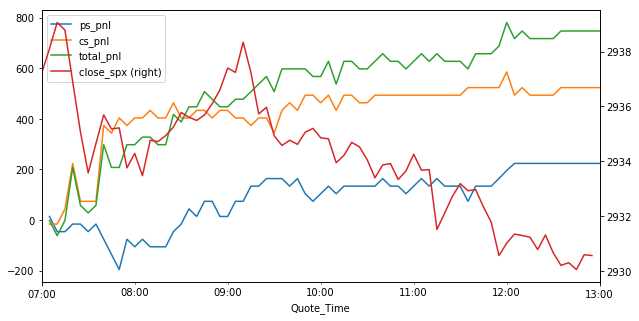

2018-09-28
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-09-28 13:00:00 914.0400 194.0400 1,108.0800        nan


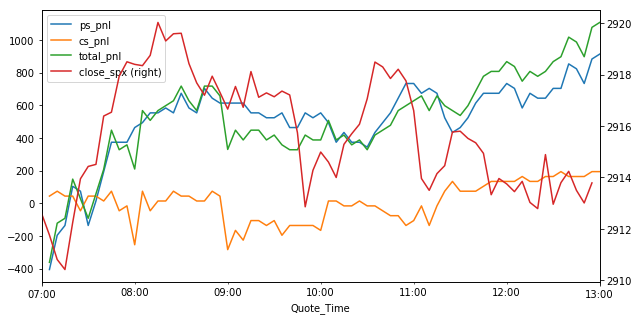

2018-10-12
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-10-12 13:00:00 615.9600 375.9600   991.9200        nan


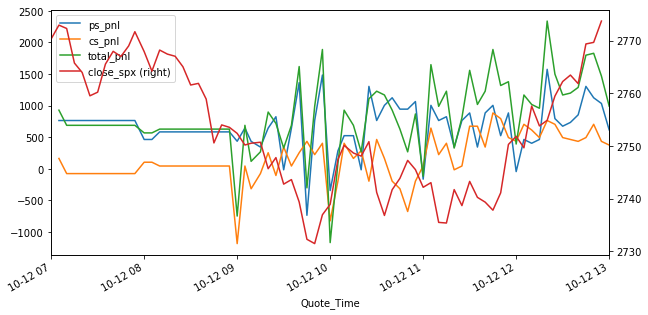

2018-10-15
                      ps_pnl    cs_pnl  total_pnl  close_spx
Quote_Time                                                  
2018-10-15 13:00:00 315.9600 -404.0400   -88.0800        nan


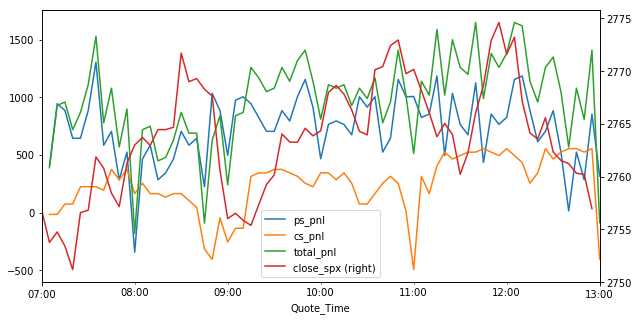

2018-10-17
                       ps_pnl     cs_pnl  total_pnl  close_spx
Quote_Time                                                    
2018-10-17 13:00:00 -164.0400 1,215.9600 1,051.9200        nan


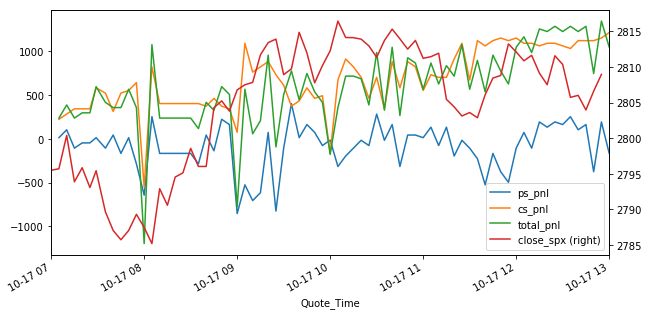

2018-10-19
                      ps_pnl     cs_pnl  total_pnl  close_spx
Quote_Time                                                   
2018-10-19 13:00:00 -75.9600 1,515.9600 1,440.0000        nan


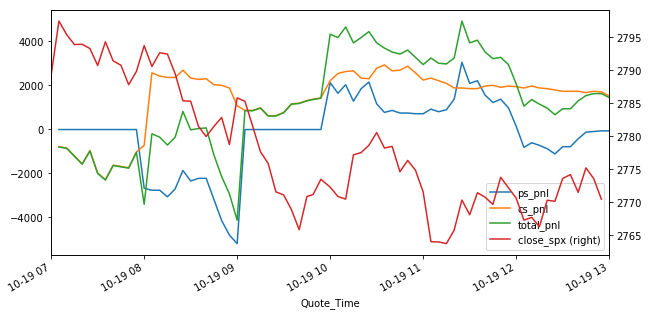

2018-10-22
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-10-22 13:00:00 315.9600 825.9600 1,141.9200        nan


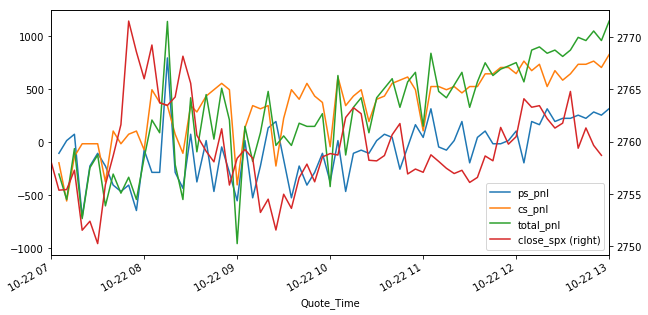

2018-10-26
                      ps_pnl     cs_pnl  total_pnl  close_spx
Quote_Time                                                   
2018-10-26 12:59:00 405.9600 2,325.9600 2,731.9200 2,658.1200


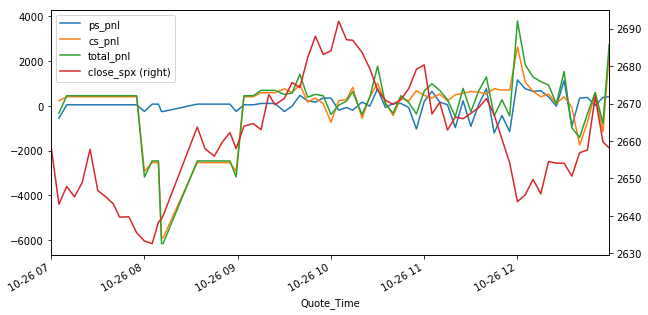

2018-10-29
                         ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                    
2018-10-29 12:59:00 -1,124.0400 224.0400  -900.0000 2,641.8100


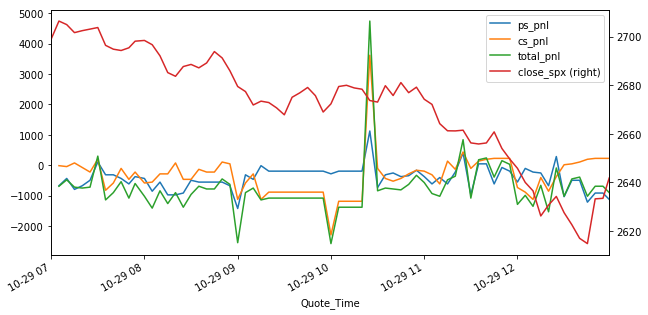

2018-10-31
                      ps_pnl      cs_pnl   total_pnl  close_spx
Quote_Time                                                     
2018-10-31 13:00:00 -44.0400 -1,514.0400 -1,558.0800        nan


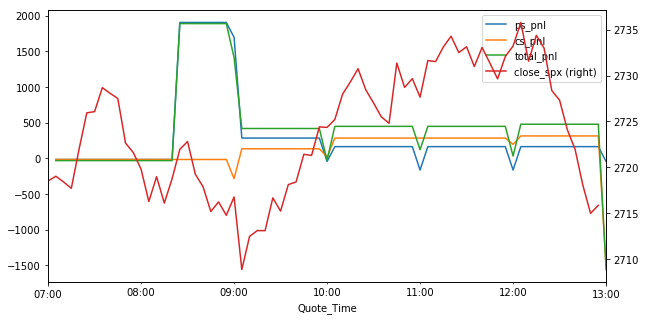

2018-11-02
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-11-02 13:00:00 -44.0400 465.9600   421.9200        nan


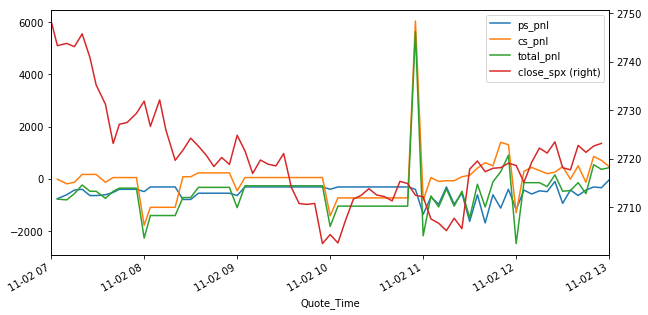

2018-11-05
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-11-05 13:00:00 314.0400 675.9600   990.0000        nan


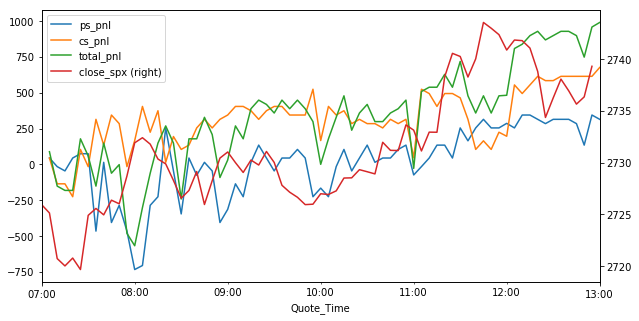

2018-11-07
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-11-07 13:00:00 285.9600 795.9600 1,081.9200        nan


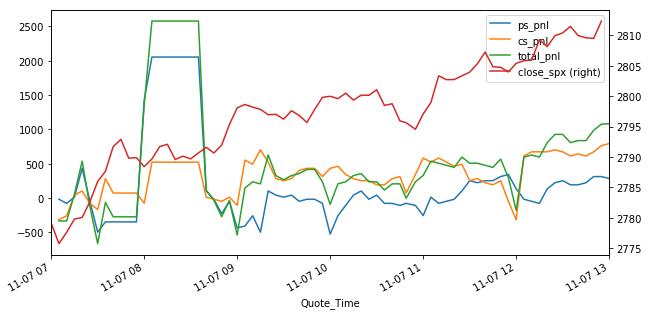

2018-11-09
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-11-09 13:00:00 465.9600 135.9600   601.9200        nan


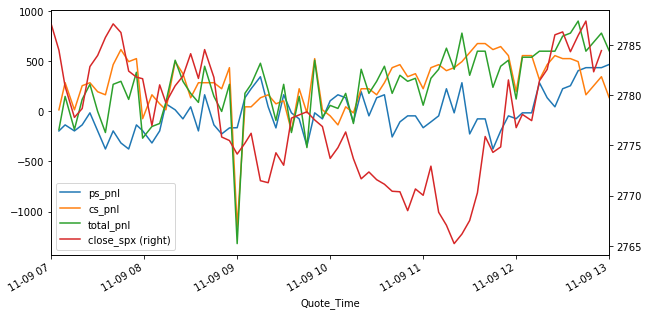

2018-11-12
                       ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                  
2018-11-12 13:00:00 -224.0400 615.9600   391.9200        nan


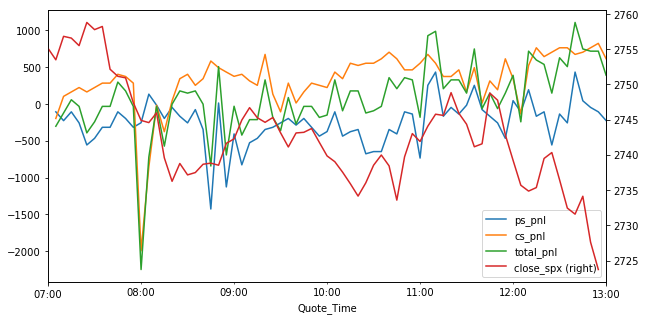

2018-11-14
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-11-14 13:00:00 495.9600 315.9600   811.9200        nan


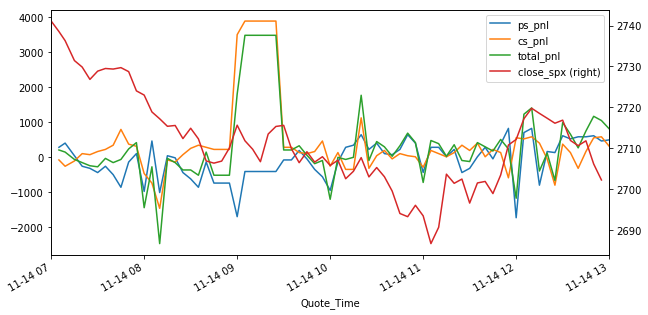

2018-11-16
                      ps_pnl      cs_pnl   total_pnl  close_spx
Quote_Time                                                     
2018-11-16 13:00:00 -15.9600 -1,095.9600 -1,111.9200        nan


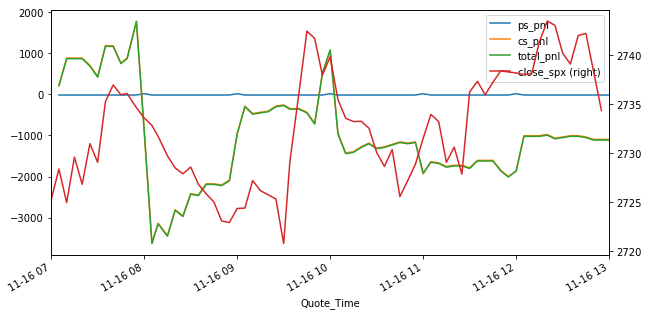

2018-11-19
                       ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                  
2018-11-19 13:00:00 -254.0400 974.0400   720.0000        nan


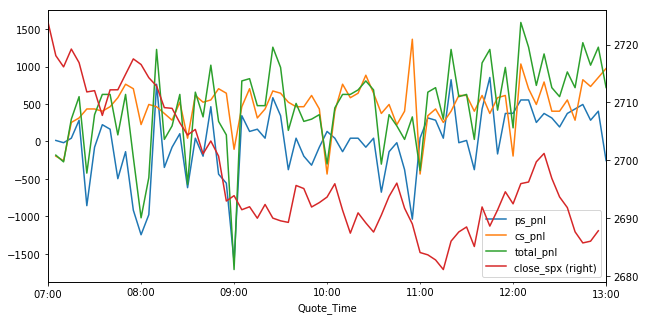

2018-11-21
                       ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                  
2018-11-21 12:59:00 -224.0400 735.9600   511.9200 2,650.1300


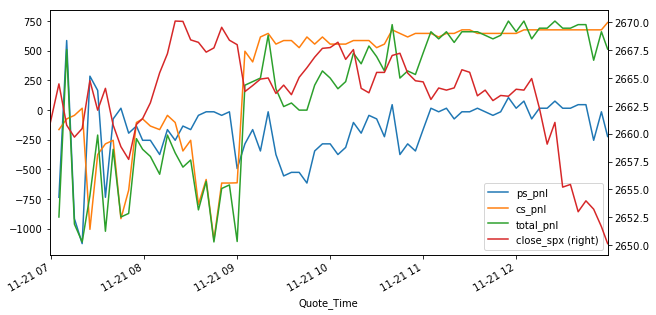

2018-11-26
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-11-26 13:00:00 494.0400 134.0400   628.0800        nan


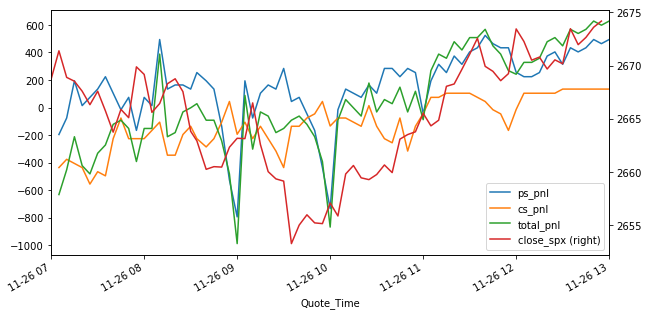

2018-11-28
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-11-28 12:58:00 404.0400 -15.9600   388.0800 2,743.5600


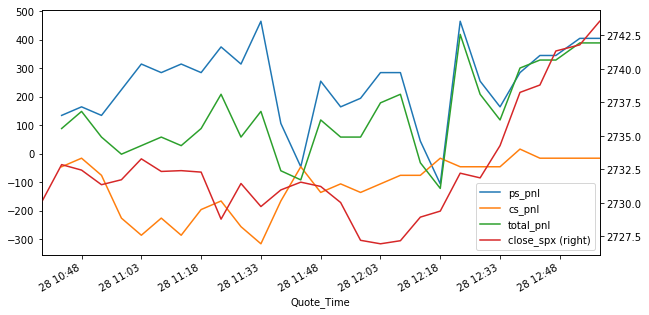

2018-11-30
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-11-30 11:10:00 314.0400 554.0400   868.0800 2,748.8500


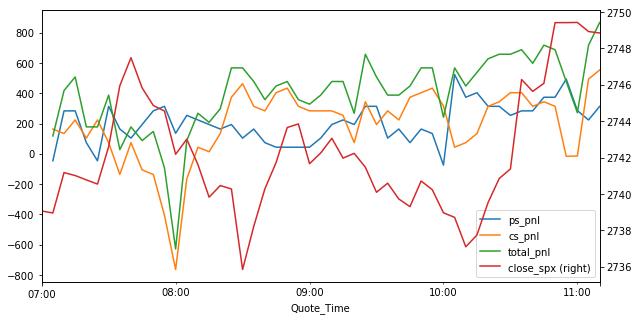

2018-12-03
                      ps_pnl     cs_pnl  total_pnl  close_spx
Quote_Time                                                   
2018-12-03 12:59:00 555.9600 1,095.9600 1,651.9200 2,790.4800


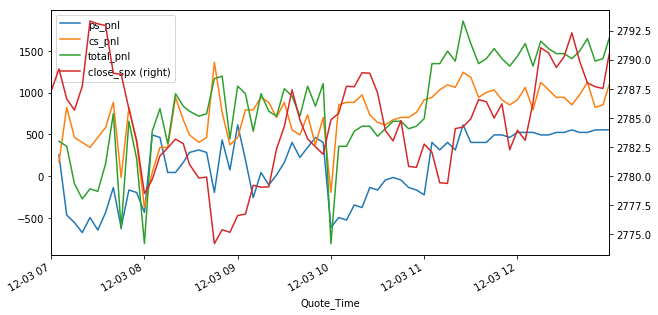

2018-12-07
                      ps_pnl    cs_pnl  total_pnl  close_spx
Quote_Time                                                  
2018-12-07 12:59:00 735.9600 -374.0400   361.9200 2,632.9900


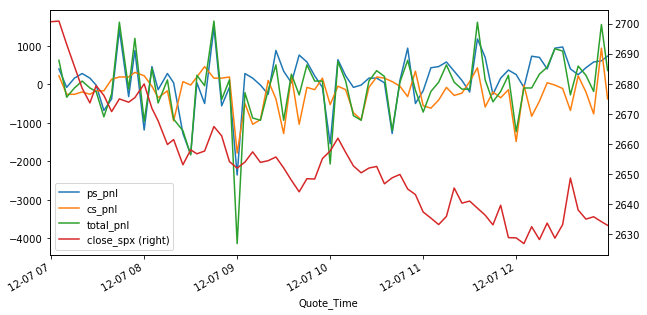

2018-12-10
                      ps_pnl    cs_pnl  total_pnl  close_spx
Quote_Time                                                  
2018-12-10 12:59:00 255.9600 -554.0400  -298.0800 2,637.8300


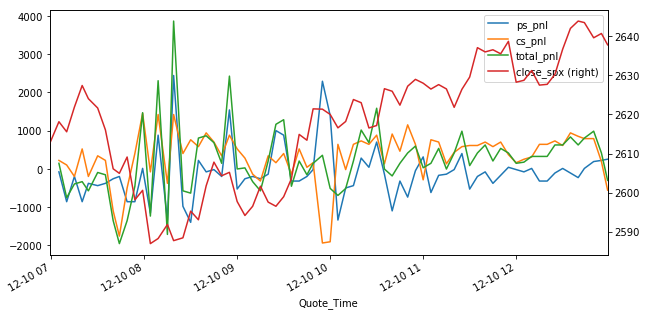

2018-12-12
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-12-12 13:00:00 675.9600 555.9600 1,231.9200        nan


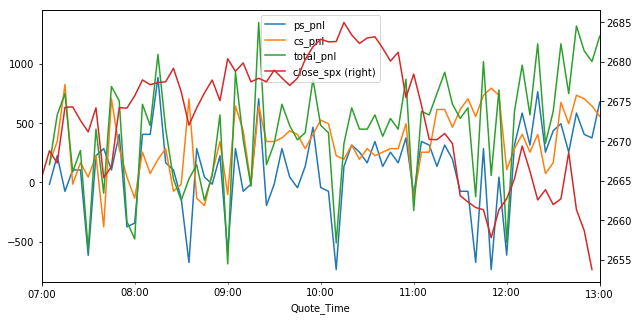

2018-12-14
                       ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                  
2018-12-14 12:59:00 -584.0400 525.9600   -58.0800 2,600.0400


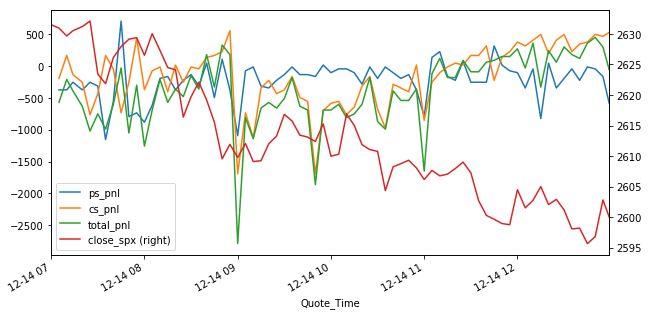

2018-12-17
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-12-17 13:00:00 585.9600 675.9600 1,261.9200        nan


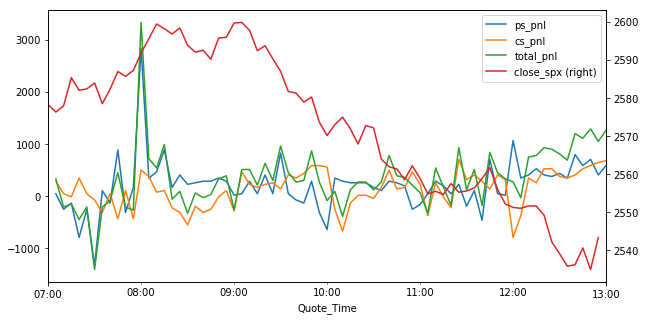

2018-12-19
                       ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                  
2018-12-19 12:59:00 -404.0400 465.9600    61.9200 2,506.5200


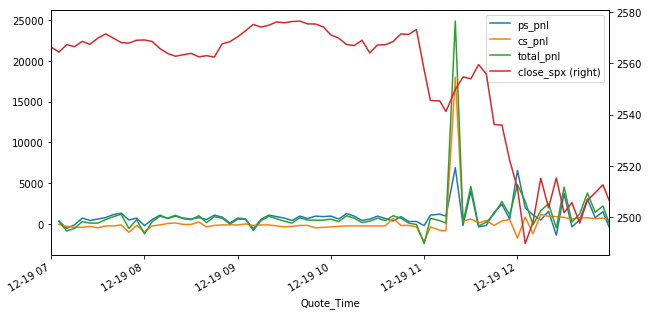

2018-12-21
                        ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                   
2018-12-21 12:59:00 2,775.9600 225.9600 3,001.9200 2,416.5700


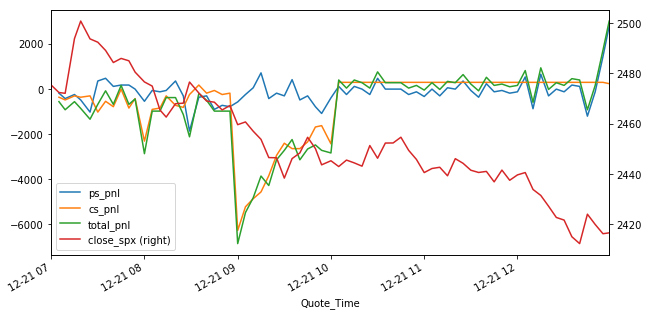

2018-12-26
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2018-12-26 13:00:00 165.9600 285.9600   451.9200        nan


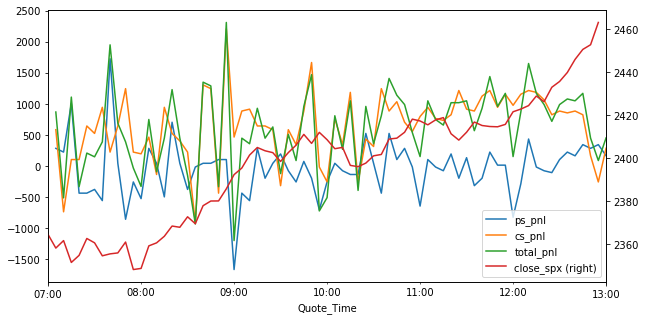

2018-12-28
                        ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                   
2018-12-28 12:59:00 1,725.9600 585.9600 2,311.9200 2,485.1900


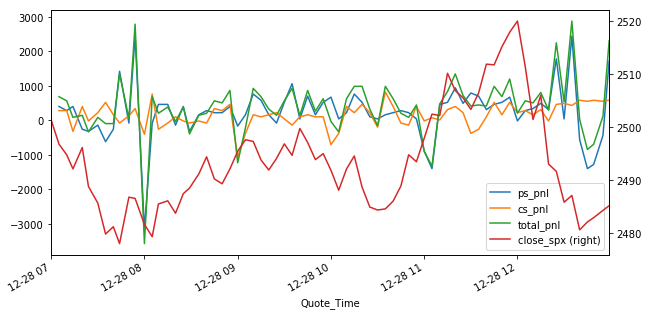

2018-12-31
                     ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                
2018-12-31 12:59:00 75.9600 495.9600   571.9200 2,506.7100


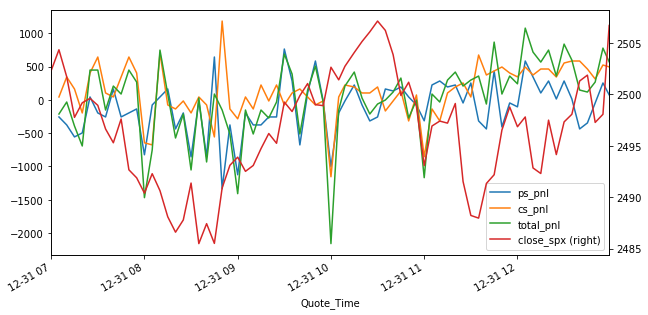

2019-01-02
                        ps_pnl     cs_pnl  total_pnl  close_spx
Quote_Time                                                     
2019-01-02 12:59:00 1,005.9600 1,845.9600 2,851.9200 2,509.7700


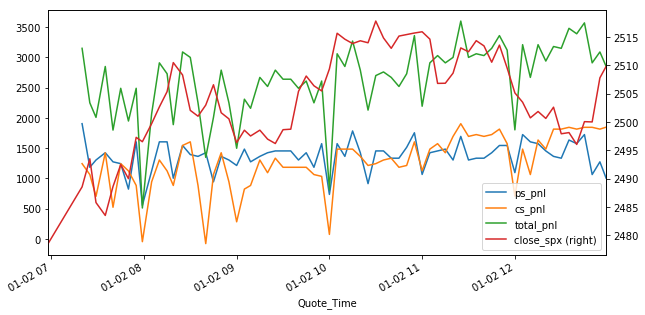

2019-01-04
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2019-01-04 12:59:00 255.9600 494.0400   750.0000 2,531.7200


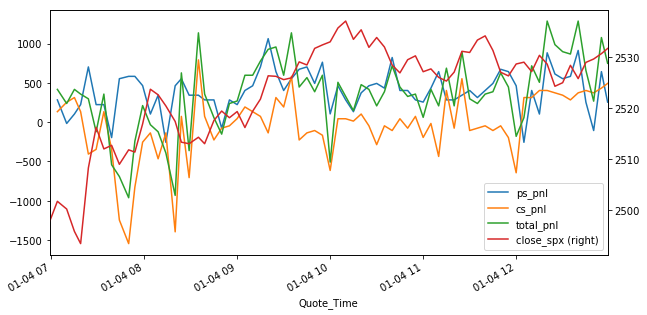

2019-01-07
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2019-01-07 12:59:00 824.0400 525.9600 1,350.0000 2,549.2600


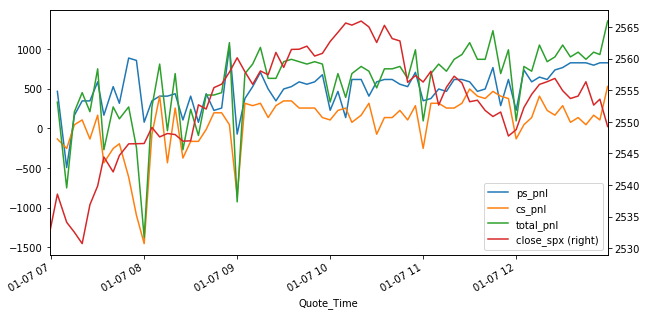

2019-01-09
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2019-01-09 13:00:00 495.9600 345.9600   841.9200        nan


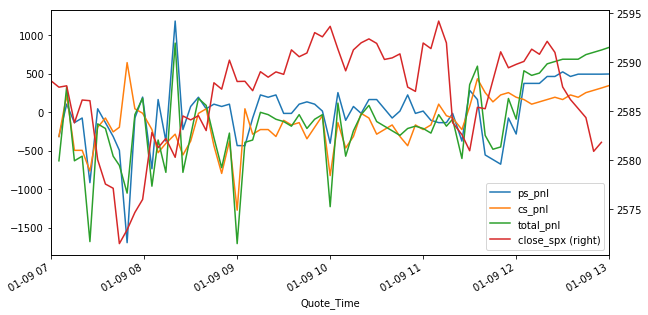

2019-01-11
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2019-01-11 13:00:00 645.9600 675.9600 1,321.9200        nan


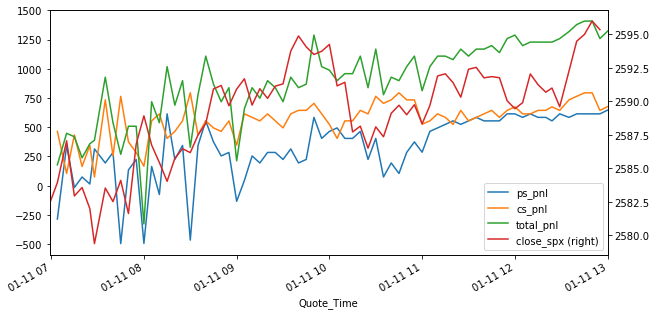

2019-01-14
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2019-01-14 13:00:00 255.9600 585.9600   841.9200        nan


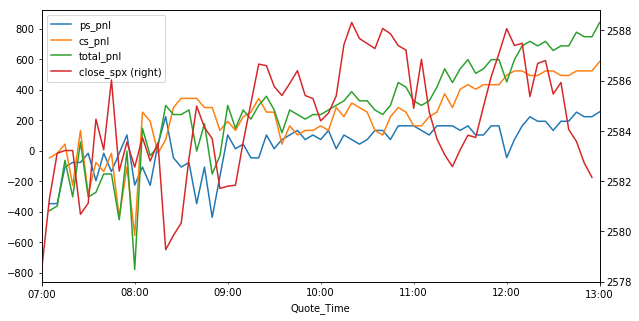

2019-01-16
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2019-01-16 13:00:00 405.9600 375.9600   781.9200        nan


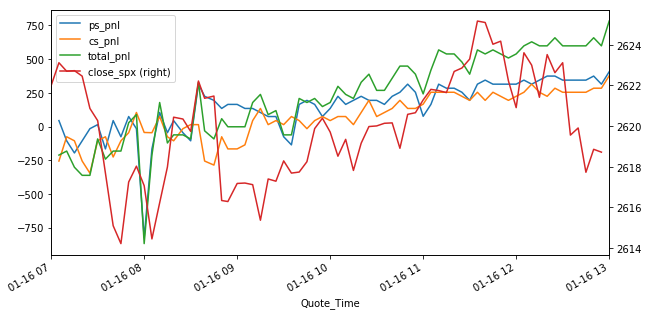

2019-01-18
                        ps_pnl  cs_pnl  total_pnl  close_spx
Quote_Time                                                  
2019-01-18 13:00:00 1,755.9600 15.9600 1,771.9200        nan


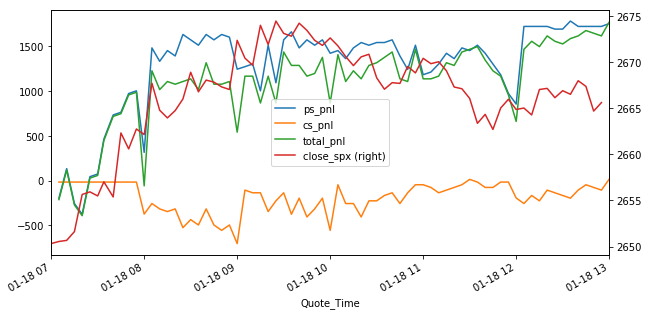

2019-01-22
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2019-01-22 13:00:00 165.9600 435.9600   601.9200        nan


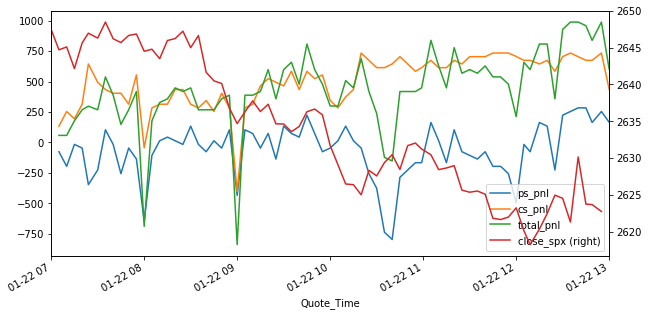

2019-01-23
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2019-01-23 13:00:00 435.9600 405.9600   841.9200        nan


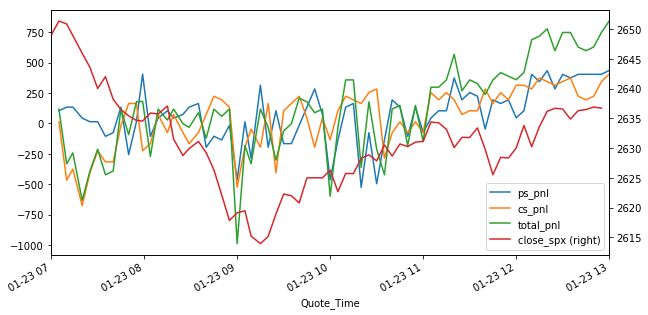

2019-01-25
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2019-01-25 13:00:00 524.0400 404.0400   928.0800        nan


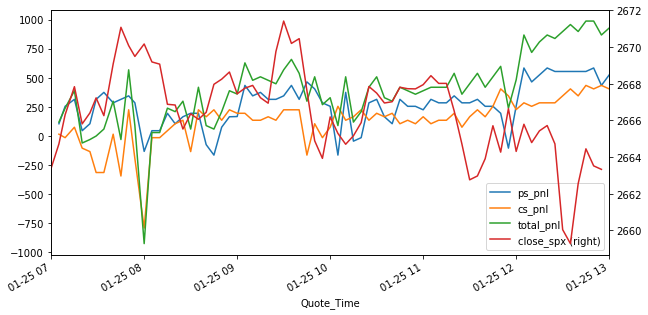

2019-01-28
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2019-01-28 13:00:00 434.0400 494.0400   928.0800        nan


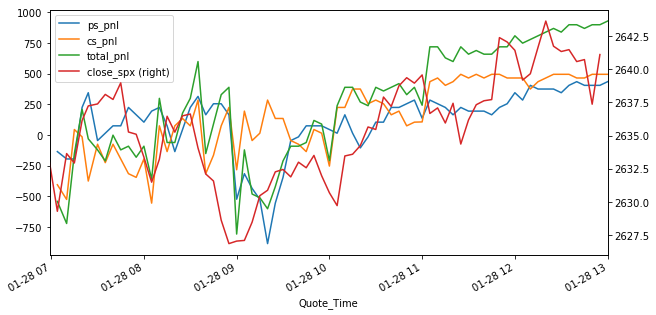

2019-01-30
                      ps_pnl     cs_pnl  total_pnl  close_spx
Quote_Time                                                   
2019-01-30 12:55:00 314.0400 1,545.9600 1,860.0000 2,680.9100


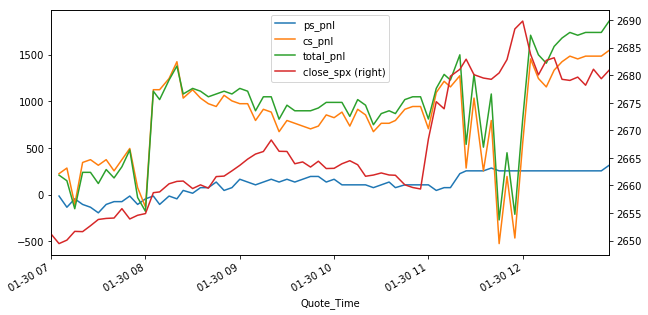

2019-01-31
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2019-01-31 12:59:00 195.9600 375.9600   571.9200 2,704.6500


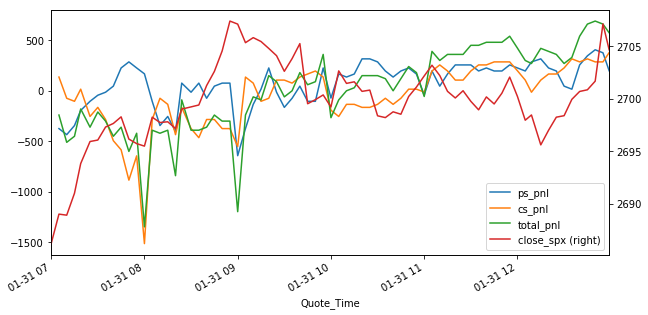

2019-02-01
                      ps_pnl     cs_pnl  total_pnl  close_spx
Quote_Time                                                   
2019-02-01 13:00:00 345.9600 1,635.9600 1,981.9200        nan


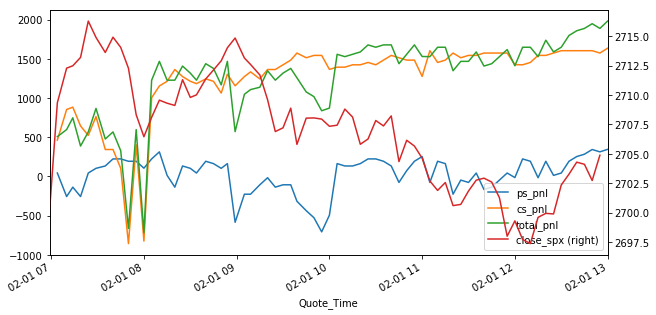

2019-02-04
                     ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                
2019-02-04 13:00:00 44.0400 194.0400   238.0800        nan


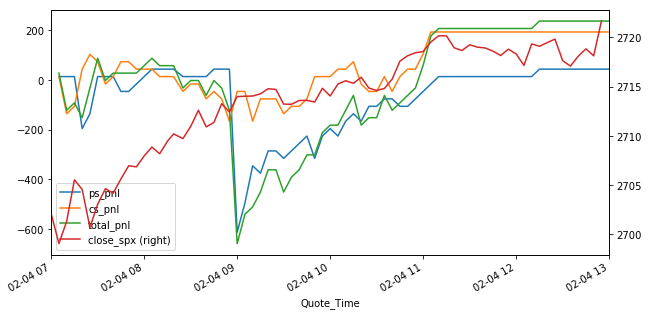

2019-02-06
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2019-02-06 12:59:00 194.0400 404.0400   598.0800 2,731.5400


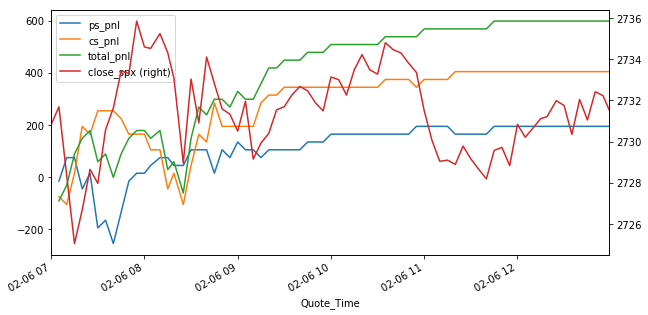

2019-02-08
                      ps_pnl     cs_pnl  total_pnl  close_spx
Quote_Time                                                   
2019-02-08 13:00:00 284.0400 1,005.9600 1,290.0000        nan


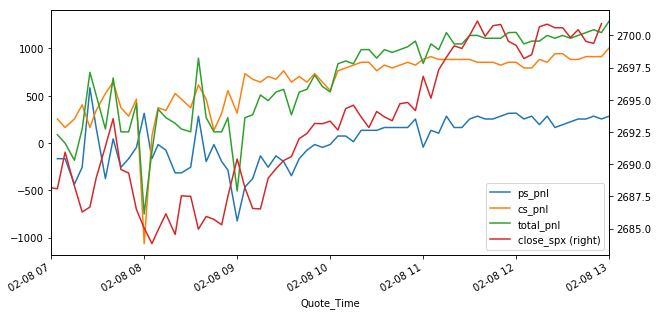

2019-02-13
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2019-02-13 13:00:00 -15.9600 404.0400   388.0800        nan


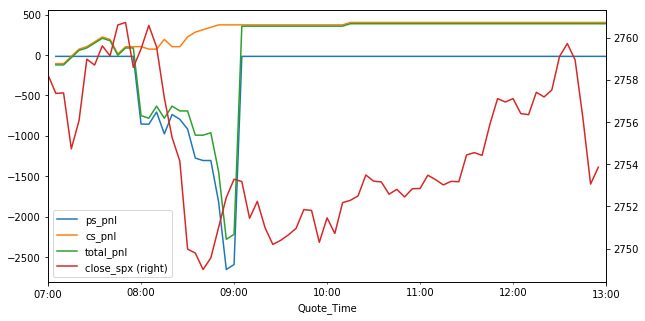

2019-02-15
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2019-02-15 12:56:00 254.0400 -15.9600   238.0800 2,774.3200


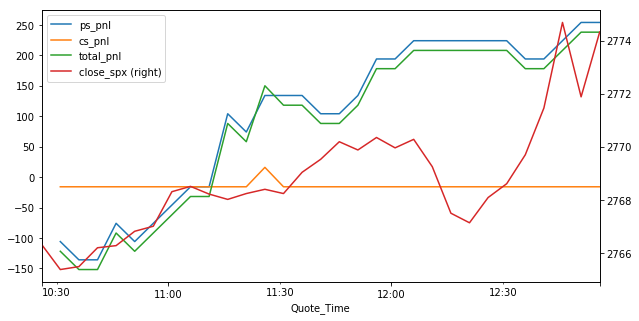

2019-02-19
                         ps_pnl   cs_pnl   total_pnl  close_spx
Quote_Time                                                     
2019-02-19 12:59:00 -1,154.0400 -74.0400 -1,228.0800 2,779.6500


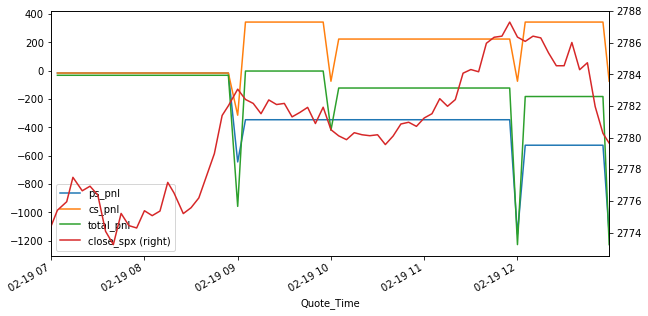

2019-02-20
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2019-02-20 12:25:00 194.0400 104.0400   298.0800 2,785.8900


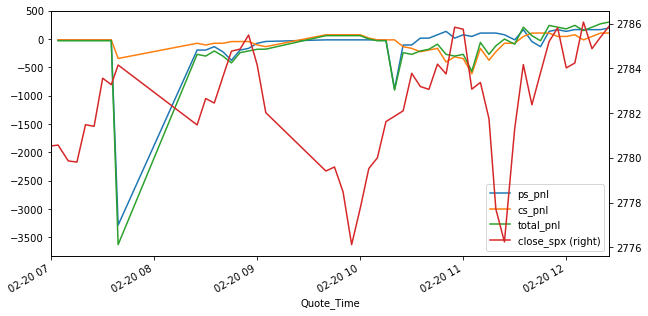

2019-02-22
                         ps_pnl    cs_pnl   total_pnl  close_spx
Quote_Time                                                      
2019-02-22 13:00:00 -1,784.0400 -344.0400 -2,128.0800        nan


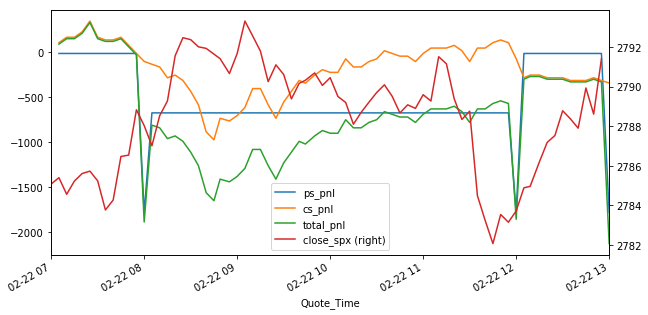

2019-02-25
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2019-02-25 12:59:00 285.9600 585.9600   871.9200 2,795.3900


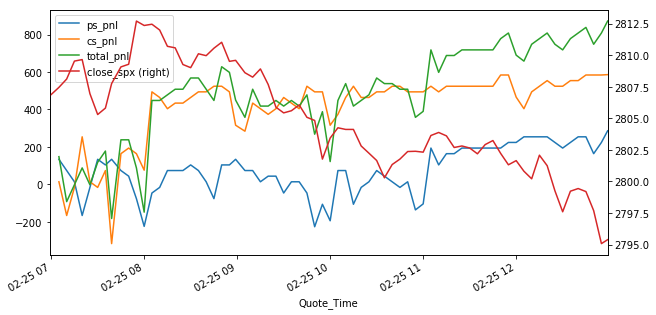

2019-02-27
                       ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                  
2019-02-27 13:00:00 -135.9600 -15.9600  -151.9200        nan


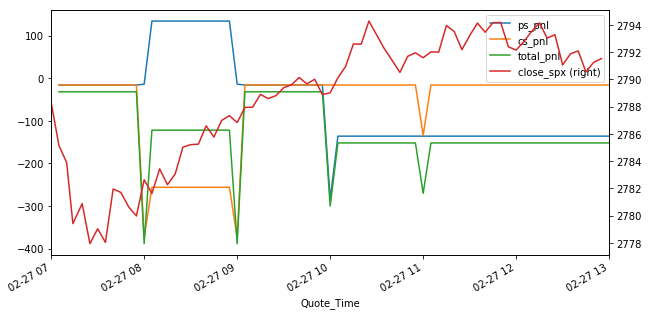

2019-02-28
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2019-02-28 12:59:00 344.0400 495.9600   840.0000 2,784.3700


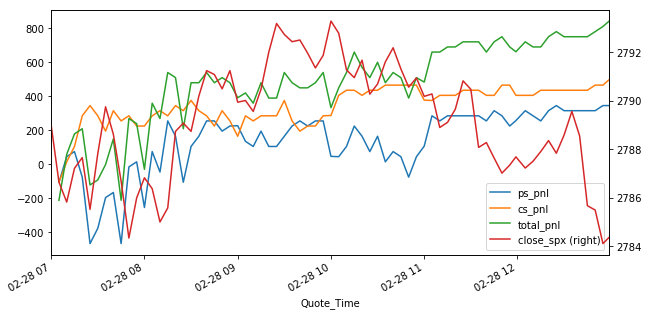

2019-03-01
                      ps_pnl   cs_pnl  total_pnl  close_spx
Quote_Time                                                 
2019-03-01 12:59:00 315.9600 465.9600   781.9200 2,803.6000


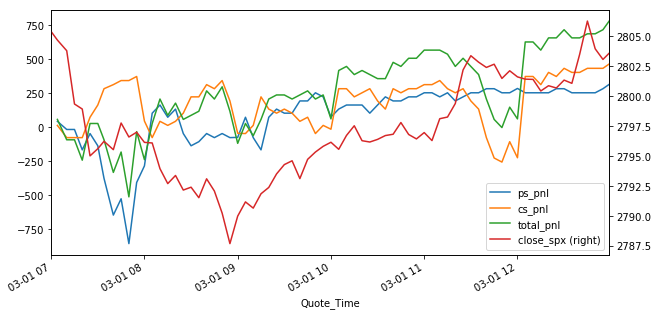

In [90]:
daily_pnl_df = []

for pnl_date in sorted(list(set(pnl_track_df.index.date))):
    curr_pnl_df = pnl_track_df[pnl_track_df.index.date == pnl_date].join(index_intraday[['close_spx']])
    curr_pnl_df.plot(figsize = (10,5), secondary_y = 'close_spx')
    print(pnl_date.strftime('%Y-%m-%d'))
    print(curr_pnl_df.tail(1))
    daily_pnl_df.append(curr_pnl_df.tail(1))
    plt.show()

In [73]:
exclude_dates = [] 

for i in range(len(ps_holdings)):
    curr_holdings_df_date = curr_ps_holdings_df.iloc[0, 0].date()
    
    curr_ps_holdings_df = ps_holdings[i]
    curr_cs_holdings_df = cs_holdings[i]
    
    check_cs_head = curr_cs_holdings_df.head(10)
    check_ps_head = curr_cs_holdings_df.head(10)
    
    if len(check_cs_head[check_cs_head.Short_Bid <= 0]) > 0 or len(check_ps_head[check_ps_head.Short_Bid <= 0]) > 0:
        exclude_dates.append(curr_holdings_df_date)

In [108]:
nav_track_df.describe()

ps_pnl       cs_pnl    total_pnl
count  5,256.0000   5,256.0000   5,256.0000
mean       3.4595       6.3602       9.8197
std      447.7353     526.0097     765.2754
min   -7,080.0000 -17,640.0000 -24,720.0000
25%      -60.0000     -60.0000     -90.0000
50%       -0.0000      -0.0000      -0.0000
75%       60.0000      60.0000     120.0000
max    5,971.9200  18,840.0000  24,780.0000

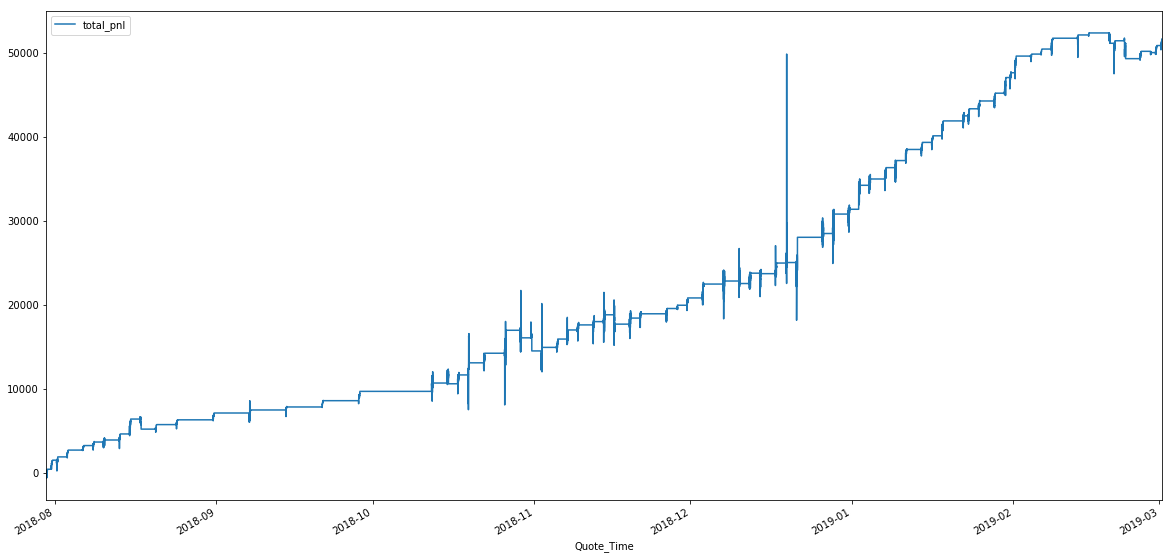

In [100]:
nav_track_df[['total_pnl']].expanding(1).sum().plot(figsize = (20,10))

In [112]:
pd.concat(daily_pnl_df, axis = 0)[['total_pnl']].describe() #

total_pnl
count     75.0000
mean     688.1632
std      885.0975
min   -2,128.0800
25%      388.0800
50%      720.0000
75%    1,065.9600
max    3,001.9200

In [129]:
intraday_data = index_intraday[['close_spx','close_vix']].tail(2000)



# trace1 = go.Bar(
#             x=intraday_data.index,
#             y=intraday_data['Dollar Std Move'],
#             name='Intraday Dollar Vol',
#             yaxis='y1',
#         )

trace2 = go.Scatter(
            x=intraday_data.index,
            y=intraday_data['close_spx'],
            mode='lines',
            yaxis='y1',
            name='SPX Close')

trace3 = go.Scatter(
            x=intraday_data.index,
            y=intraday_data['close_vix'],
            mode='lines',
            yaxis='y2',
            name='VIX Close')

# trace4 = go.Scatter(
#             x=intraday_data.index,
#             y=intraday_data['SMA 5'],
#             mode='lines',
#             yaxis='y4',
#             name='SPX SMA 5')


layout = go.Layout(
        title='SPX Intraday',
#         yaxis=dict(
#                 title='Dollar Return Std.',
#                 side='right'),
        yaxis=dict(
                #range=[intraday_data.Last.min(),intraday_data.Last.max()],
                title='SPX',
                #overlaying='y',
                side='right',
                showgrid=False,
                zeroline=False,
                showline=False,
                ticks='',
                showticklabels=False
                ),
        yaxis2=dict(
                #range=[intraday_data.Last.min(),intraday_data.Last.max()],
                title='VIX',
                overlaying='y',
                side='left',
                showgrid=False,
                zeroline=False,
                showline=False,
                ticks='',
                showticklabels=False
                )
#         yaxis4=dict(
#                 range=[intraday_data.Last.min(),intraday_data.Last.max()],
#                 title='SPX SMA 5',
#                 overlaying='y',
#                 side='left',
#                 showgrid=False,
#                 zeroline=False,
#                 showline=False,
#                 ticks='',
#                 showticklabels=False
#                 )
        )

data = [trace2, trace3]
figure = dict(data=data, layout=layout)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [3]:
options_files = sorted(os.listdir())

daylights_savings = dt.datetime(2018,11,4)

period_window = 60
commissions = 0.0266
number_of_contracts = 6

In [161]:
eod_options = list(filter(lambda x: '13-00.csv' in x, options_files))

commissions = 0.0266

eod_options = list(set([dt.datetime.strptime(x.split('.csv')[0][:-6].replace('spx_',''), '%Y-%m-%d') for x in options_files]))
eod_options = [x.strftime('%Y-%m-%d') for x in sorted(eod_options)]

eod_files = []
for eod_option in eod_options:
    all_eod_files = sorted(list(filter(lambda x: eod_option in x, options_files)))
    try:
        eod_file = sorted(list(filter(lambda x: x[-9:-7] == '13', all_eod_files)))[0]
        eod_files.append(eod_file)
    except:
        continue
    
eod_options = eod_files

trades = []

previous_date = dt.datetime(2018,7,30,0,0)
for option_file in eod_options:
    
    curr_datetime = dt.datetime.strptime(option_file.split('.csv')[0][:-6].replace('spx_',''), '%Y-%m-%d')
    
    
    curr_index_data = index_intraday[index_intraday.date_day == curr_datetime.date()].sort_index().tail(1)
    
    if len(curr_index_data) == 0:
        continue
        
    curr_spx_index = curr_index_data.reset_index().loc[0,'close_spx']
    curr_iv_1day = curr_index_data.reset_index().loc[0,'close_vix']/(100*np.sqrt(365.25))

    curr_lower_strike = curr_spx_index*np.exp(norm.ppf(0.2, 0, curr_iv_1day))
    
    
    
    curr_chains = pd.read_csv(option_file, index_col = 0)[['Strike','Expiry','Type',
                                                           'Symbol','Bid','Ask','Vol','Open_Int',
                                                           'IV','Underlying_Price','Quote_Time']]

    curr_chains.Quote_Time = pd.to_datetime(curr_chains.Quote_Time).map(lambda x: x.replace(second=0))

    if curr_chains.Quote_Time[0] < daylights_savings:
        curr_chains.Quote_Time = curr_chains.Quote_Time - dt.timedelta(seconds = 60*60*7)
    else:
        curr_chains.Quote_Time = curr_chains.Quote_Time - dt.timedelta(seconds = 60*60*8)

    curr_chains.Expiry = pd.to_datetime(curr_chains.Expiry)

    curr_chains['DTE'] = (curr_chains.Expiry - curr_chains.Quote_Time).dt.days + 1
    
    ############### Getting Current Trades ##############
    if curr_chains.DTE.min() == 0:
        curr_puts_dte = curr_chains[(curr_chains.Type == 'put') & (curr_chains.DTE > 0)].DTE.min()
    else:
        curr_puts_dte = curr_chains.DTE.min()

    curr_puts = curr_chains[(curr_chains.Type == 'put') &
                            (curr_chains.Strike < curr_lower_strike) &
                            (curr_chains.DTE == curr_puts_dte)].sort_values('Strike',ascending = False).head(2).reset_index(drop = True)
    
    curr_ps = pd.DataFrame(columns = ['Quote_Time','DTE','Short_Symbol','Long_Symbol',
                                      'Short_Bid','Long_Ask'],
                           index = [0])
    curr_ps.loc[0, 'Quote_Time'] = curr_puts.loc[0, 'Quote_Time']
    curr_ps.loc[0, 'DTE'] = curr_puts.loc[0, 'DTE']
    curr_ps.loc[0, 'Short_Symbol'] = curr_puts.loc[0, 'Symbol']
    curr_ps.loc[0, 'Long_Symbol'] = curr_puts.loc[1, 'Symbol']
    curr_ps.loc[0, 'Short_Bid'] = curr_puts.loc[0, 'Bid']
    curr_ps.loc[0, 'Long_Ask'] = curr_puts.loc[1, 'Ask']
    curr_ps['Credit'] = curr_ps.Short_Bid - curr_ps.Long_Ask
    
    trades.append(curr_ps)
    
trades = pd.concat(trades, axis = 0).reset_index(drop = True)

In [ ]:
eod_options_df = []

for options_file in eod_options:
    next_chains = pd.read_csv(options_file, index_col = 0)[['Strike','Expiry','Type',
                                                       'Symbol','Bid','Ask','Vol','Open_Int',
                                                       'IV','Underlying_Price','Quote_Time']]
    next_chains.Quote_Time = pd.to_datetime(next_chains.Quote_Time).map(lambda x: x.replace(second=0))
    next_chains.Expiry = pd.to_datetime(next_chains.Expiry)
    next_chains['DTE'] = (next_chains.Expiry - next_chains.Quote_Time).dt.days + 1
    next_chains = next_chains[next_chains.Type == 'put']
    eod_options_df.append(next_chains)
    
eod_options_df = pd.concat(eod_options_df, axis = 0).reset_index(drop = True)

In [250]:
ending_vals = []

i = 1
for idx, trade in trades.iterrows():
    curr_trade = trade
    
    next_puts = eod_options_df[(eod_options_df.Symbol.isin([curr_trade.Short_Symbol, 
                                                           curr_trade.Long_Symbol])) &
                               (eod_options_df.DTE == 0)].sort_values('Strike', 
                                                                      ascending = False).reset_index(drop = True)
    next_ps = pd.DataFrame(columns = ['Quote_Time','DTE','Short_Symbol','Long_Symbol',
                                  'Short_Bid','Long_Ask'],
                           index = [0])
    if len(next_puts) < 2:
        next_ps = pd.DataFrame(curr_trade).T.reset_index(drop = True)
        next_ps['Credit'] = np.nan
    else:
        
        next_ps.loc[0, 'Quote_Time'] = next_puts.loc[0, 'Quote_Time']
        next_ps.loc[0, 'DTE'] = next_puts.loc[0, 'DTE']
        next_ps.loc[0, 'Short_Symbol'] = next_puts.loc[0, 'Symbol']
        next_ps.loc[0, 'Long_Symbol'] = next_puts.loc[1, 'Symbol']
        next_ps.loc[0, 'Short_Bid'] = next_puts.loc[0, 'Bid']
        next_ps.loc[0, 'Long_Ask'] = next_puts.loc[1, 'Ask']
        next_ps['Credit'] = next_ps.Short_Bid - next_ps.Long_Ask
    
    ending_vals.append(next_ps)

In [258]:
dte1_test = trades.join(pd.concat(ending_vals,axis = 0).reset_index(drop = True), lsuffix = '_trade', rsuffix = '_ending')

Quote_Time_trade DTE_trade   Short_Symbol_trade    Long_Symbol_trade  \
0    2018-07-30 12:59:00         1  SPXW180731P02780000  SPXW180731P02775000   
1    2018-07-31 13:00:00         1  SPXW180801P02800000  SPXW180801P02795000   
2    2018-08-01 13:00:00         2  SPXW180803P02795000  SPXW180803P02790000   
3    2018-08-02 12:59:00         1  SPXW180803P02810000  SPXW180803P02805000   
4    2018-08-03 13:00:00         3  SPXW180806P02825000  SPXW180806P02820000   
5    2018-08-06 13:00:00         2  SPXW180808P02835000  SPXW180808P02830000   
6    2018-08-07 13:00:00         1  SPXW180808P02840000  SPXW180808P02835000   
7    2018-08-08 13:00:00         2  SPXW180810P02840000  SPXW180810P02835000   
8    2018-08-09 13:00:00         1  SPXW180810P02760000  SPXW180810P02750000   
9    2018-08-10 13:00:00         3  SPXW180813P02815000  SPXW180813P02810000   
10   2018-08-13 12:59:00         2  SPXW180815P02800000  SPXW180815P02795000   
11   2018-08-14 13:00:00         1  SPXW180815P02820000  SPXW180815P02810000   
12   2018-08-15 13:00:00         2  SPXW180817P02795000  SPXW180817P02790000   
13   2018-08-16 13:00:00         1  SPXW180817P02820000  SPXW180817P02815000   
14   2018-08-17 13:00:00         3  SPXW180820P02815000  SPXW180820P02800000   
15   2018-08-20 13:00:00         4  SPXW180824P02840000  SPXW180824P02835000   
16   2018-08-21 13:00:00         3  SPXW180824P02845000  SPXW180824P02840000   
17   2018-08-22 13:00:00         2  SPXW180824P02845000  SPXW180824P02840000   
18   2018-08-23 13:00:00         1  SPXW180824P02840000  SPXW180824P02835000   
19   2018-08-24 13:00:00         7  SPXW180831P02855000  SPXW180831P02850000   
20   2018-08-27 13:00:00         4  SPXW180831P02880000  SPXW180831P02875000   
21   2018-08-28 13:00:00         3  SPXW180831P02880000  SPXW180831P02875000   
22   2018-08-29 13:00:00         2  SPXW180831P02890000  SPXW180831P02885000   
23   2018-08-30 13:00:00         1  SPXW180831P02880000  SPXW180831P02875000   
24   2018-08-31 13:00:00         7  SPXW180907P02870000  SPXW180907P02865000   
25   2018-09-04 13:00:00         3  SPXW180907P02870000  SPXW180907P02865000   
26   2018-09-05 13:00:00         2  SPXW180907P02870000  SPXW180907P02865000   
27   2018-09-06 13:00:00         1  SPXW180907P02855000  SPXW180907P02850000   
28   2018-09-07 13:00:00         7  SPXW180914P02825000  SPXW180914P02810000   
29   2018-09-10 13:00:00         4  SPXW180914P02825000  SPXW180914P02810000   
..                   ...       ...                  ...                  ...   
117  2019-01-17 13:00:00         1  SPXW190118P02610000  SPXW190118P02605000   
118  2019-01-18 13:00:00         4  SPXW190122P02645000  SPXW190122P02640000   
119  2019-01-22 13:00:00         1  SPXW190123P02610000  SPXW190123P02605000   
120  2019-01-23 13:00:00         2  SPXW190125P02615000  SPXW190125P02610000   
121  2019-01-24 13:00:00         1  SPXW190125P02620000  SPXW190125P02615000   
122  2019-01-25 13:00:00         3  SPXW190128P02640000  SPXW190128P02625000   
123  2019-01-28 13:00:00         2  SPXW190130P02615000  SPXW190130P02600000   
124  2019-01-29 13:00:00         1  SPXW190130P02615000  SPXW190130P02600000   
125  2019-01-30 12:55:00         1  SPXW190131P02660000  SPXW190131P02655000   
126  2019-01-31 12:59:00         1  SPXW190201P02680000  SPXW190201P02675000   
127  2019-02-01 13:00:00         3  SPXW190204P02675000  SPXW190204P02670000   
128  2019-02-04 13:00:00         2  SPXW190206P02700000  SPXW190206P02640000   
129  2019-02-05 12:59:00         1  SPXW190206P02700000  SPXW190206P02640000   
130  2019-02-06 12:59:00         2  SPXW190208P02710000  SPXW190208P02705000   
131  2019-02-07 13:00:00         1  SPXW190208P02685000  SPXW190208P02680000   
132  2019-02-08 13:00:00         3  SPXW190211P02675000  SPXW190211P02650000   
133  2019-02-11 13:00:00         2  SPXW190213P02615000  SPXW190213P02600000   
134  2019-02-12 12:59:00         1  SPXW190213P02615000  SPXW190213P02600000   
135  201

In [256]:
os.getcwd()

'D:\\Options Data\\SPX'